In [64]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

import random
import empyrical

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['figure.figsize'] = (8, 6)  

def report(tradelist,initial_capital,type_analisy,Benchmark):
    
    %matplotlib inline
    import quantstats as qs
    qs.extend_pandas()

    tradelist = tradelist.fillna(0)
    tradelist = tradelist[tradelist!=0]
    tradelist.iloc[0] = tradelist.iloc[0]+initial_capital
    tradelist = tradelist.cumsum()

    if type_analisy == 0:
        qs.plots.snapshot(tradelist)

    if type_analisy == 1:    
        if len(Benchmark)==0:
            qs.reports.basic(tradelist)
        else:
            qs.reports.basic(tradelist,Benchmark)

    if type_analisy == 2:    
        if len(Benchmark)==0:
            qs.reports.full(tradelist)
        else:
            qs.reports.full(tradelist,Benchmark)

In [2]:
data  = pd.read_csv("big_data.csv" , header=[0, 1], index_col=0)
data.index = pd.to_datetime(data.index)
data.tail()

AUDCAD                                            AUDCHF  \
               open     high      low    close bigpointvalue     open   
time                                                                    
2023-11-27  0.89598  0.90138  0.89582  0.89947        111609  0.57954   
2023-11-28  0.89923  0.90417  0.89750  0.90243        111206  0.58036   
2023-11-29  0.90183  0.90425  0.89771  0.89918        110885  0.58354   
2023-11-30  0.89897  0.90261  0.89404  0.89552        111238  0.57725   
2023-12-01  0.89573  0.90153  0.89365  0.90077        111640  0.57807   

                                                     ...   USDCHF           \
               high      low    close bigpointvalue  ...     open     high   
time                                                 ...                     
2023-11-27  0.58208  0.57944  0.58157        172550  ...  0.88152  0.88280   
2023-11-28  0.58407  0.58036  0.58375        172306  ...  0.88025  0.88187   
2023-11-29  0.58496  0.57767  0.57824        171367  ...  0.87771  0.87841   
2023-11-30  0.58034  0.57580  0.57804        173235  ...  0.87379  0.87707   
2023-12-01  0.58076  0.57668  0.58003        172989  ...  0.87484  0.87684   

                                             USDJPY                    \
                low    close bigpointvalue     open     high      low   
time                                                                    
2023-11-27  0.87936  0.88029        113440  149.412  149.674  148.549   
2023-11-28  0.87612  0.87801        113604  148.670  148.828  147.323   
2023-11-29  0.87201  0.87384        113932  147.479  147.908  146.670   
2023-11-30  0.86847  0.87517        114443  147.234  148.510  146.841   
2023-12-01  0.86791  0.86900        114306  148.174  148.347  146.661   

                                   
              close bigpointvalue  
time                               
2023-11-27  148.681           669  
2023-11-28  147.465           672  
2023-11-29  147.232           678  
2023-11-30  148.224           679  
2023-12-01  146.804           674  

[5 rows x 140 columns]

In [3]:
asset_list = data.columns.get_level_values(0).unique().tolist()
asset_list

['AUDCAD',
 'AUDCHF',
 'AUDJPY',
 'AUDNZD',
 'AUDUSD',
 'CADCHF',
 'CADJPY',
 'CHFJPY',
 'EURAUD',
 'EURCAD',
 'EURCHF',
 'EURGBP',
 'EURJPY',
 'EURNZD',
 'EURUSD',
 'GBPAUD',
 'GBPCAD',
 'GBPCHF',
 'GBPJPY',
 'GBPNZD',
 'GBPUSD',
 'NZDCAD',
 'NZDCHF',
 'NZDJPY',
 'NZDUSD',
 'USDCAD',
 'USDCHF',
 'USDJPY']

  0%|          | 0/28 [00:00<?, ?it/s]

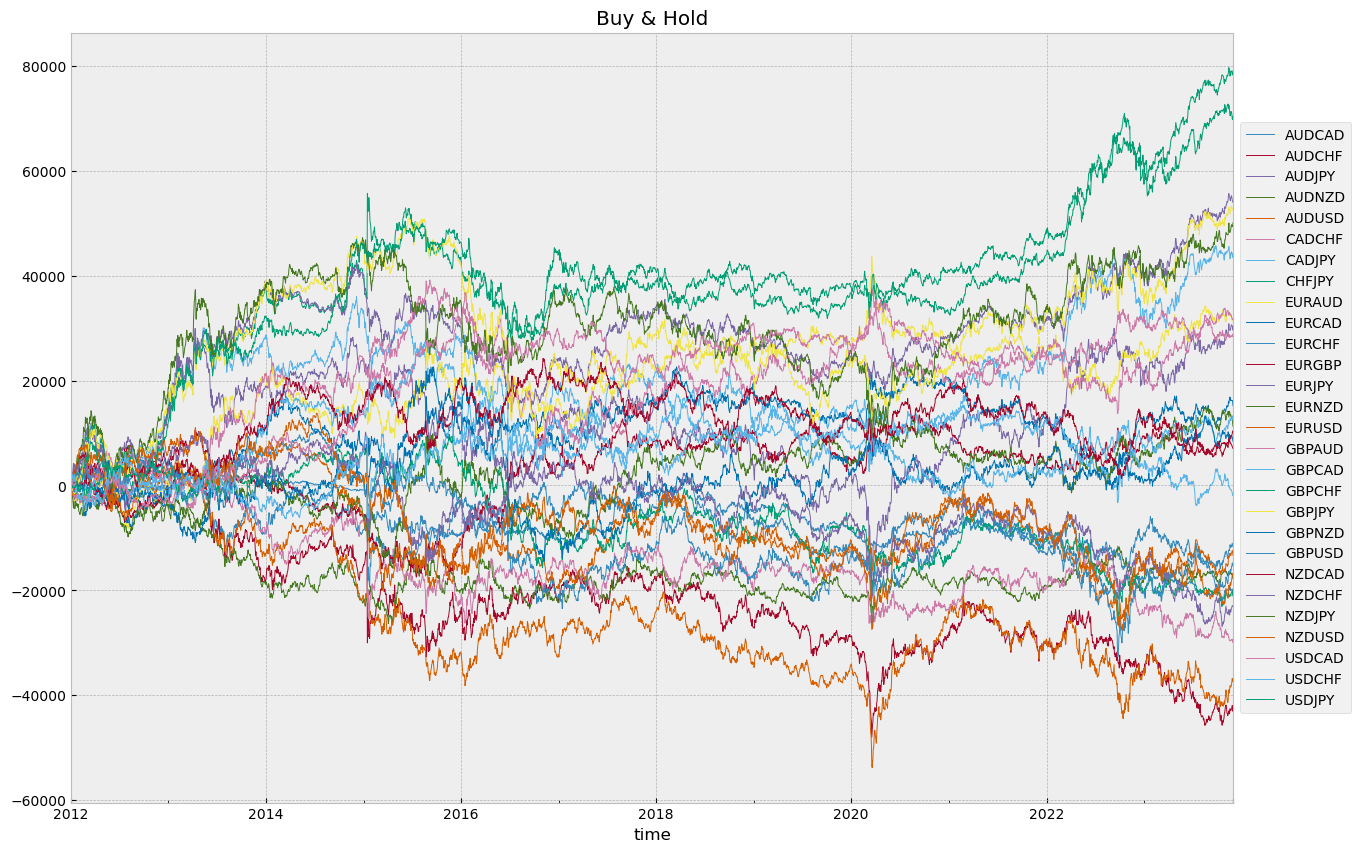

In [4]:
pnl = pd.DataFrame()

for asset in tqdm(asset_list):
    
    df = data.loc[:, asset]
    buy_and_hold = ((df.open.shift(-1)-df.open)*df.bigpointvalue).to_frame(asset)
    pnl = pd.concat([pnl,buy_and_hold],axis=1)
    
pnl=pnl.fillna(0)
pnl.cumsum().plot(figsize=(15,10) ,title="Buy & Hold")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [5]:
def preprocess(dataset):
    
    dataset_perc = dataset.apply(lambda x: np.log(x)).pct_change()
    
    LPERC = 0.01
    HPERC = 0.99

    for column in dataset_perc.columns:
        lower_perc = dataset_perc[column].quantile(LPERC)
        higher_perc = dataset_perc[column].quantile(HPERC)
        dataset_perc[column] = dataset_perc[column].clip(lower_perc,higher_perc)
        
    dataset_perc["avg_close(5)"] = dataset_perc.close.rolling(5).mean()
    dataset_perc["avg_close(20)"] = dataset_perc.close.rolling(20).mean()
    dataset_perc["avg_close(50)"] = dataset_perc.close.rolling(50).mean()
    dataset_perc["avg_close(100)"] = dataset_perc.close.rolling(100).mean()
    dataset_perc["avg_close(200)"] = dataset_perc.close.rolling(200).mean()

    dataset_perc["std_close(5)"] = dataset_perc.close.rolling(5).std()
    dataset_perc["std_close(20)"] = dataset_perc.close.rolling(20).std()
    dataset_perc["std_close(50)"] = dataset_perc.close.rolling(50).std()
    dataset_perc["std_close(100)"] = dataset_perc.close.rolling(100).std()
    dataset_perc["std_close(200)"] = dataset_perc.close.rolling(200).std()

    dataset_perc["max_high(5)"] = dataset_perc.high.rolling(5).max()
    dataset_perc["max_high(20)"] = dataset_perc.high.rolling(20).max()
    dataset_perc["max_high(50)"] = dataset_perc.high.rolling(50).max()
    dataset_perc["max_high(100)"] = dataset_perc.high.rolling(100).max()
    dataset_perc["max_high(200)"] = dataset_perc.high.rolling(200).max()

    dataset_perc["min_low(5)"] = dataset_perc.low.rolling(5).min()
    dataset_perc["min_low(20)"] = dataset_perc.low.rolling(20).min()
    dataset_perc["min_low(50)"] = dataset_perc.low.rolling(50).min()
    dataset_perc["min_low(100)"] = dataset_perc.low.rolling(100).min()
    dataset_perc["min_low(200)"] = dataset_perc.low.rolling(200).min()
        
    dataset_perc["sharpe_ratio(5)"] = dataset_perc.close.rolling(5).apply(empyrical.sharpe_ratio)    
    dataset_perc["sharpe_ratio(20)"] = dataset_perc.close.rolling(20).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio(50)"] = dataset_perc.close.rolling(50).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio(100)"] = dataset_perc.close.rolling(100).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio(200)"] = dataset_perc.close.rolling(200).apply(empyrical.sharpe_ratio)
    
    dataset_perc["omega_ratio(5)"] = dataset_perc.close.rolling(5).apply(empyrical.omega_ratio)    
    dataset_perc["omega_ratio(20)"] = dataset_perc.close.rolling(20).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio(50)"] = dataset_perc.close.rolling(50).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio(100)"] = dataset_perc.close.rolling(100).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio(200)"] = dataset_perc.close.rolling(200).apply(empyrical.omega_ratio)
    
    dataset_perc["sortino_ratio(5)"] = dataset_perc.close.rolling(5).apply(empyrical.sortino_ratio)    
    dataset_perc["sortino_ratio(20)"] = dataset_perc.close.rolling(20).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio(50)"] = dataset_perc.close.rolling(50).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio(100)"] = dataset_perc.close.rolling(100).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio(200)"] = dataset_perc.close.rolling(200).apply(empyrical.sortino_ratio)
    
                
    df_temp = pd.DataFrame()
    shift_range = 5
    
    ls_t = ["avg_close(5)","avg_close(20)","avg_close(50)","avg_close(100)","avg_close(200)"]   
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)
 
                
    ls_t = ["std_close(5)","std_close(20)","std_close(50)","std_close(100)","std_close(200)"]   
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)
               
    ls_t = ["max_high(5)","max_high(20)","max_high(50)","max_high(100)","max_high(200)"]      
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)
 
    ls_t = ["min_low(5)","min_low(20)","min_low(50)","min_low(100)","min_low(200)"] 
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)

    ls_t = ["sharpe_ratio(5)","sharpe_ratio(20)","sharpe_ratio(50)","sharpe_ratio(100)","sharpe_ratio(200)"]  
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)                    

                        
    ls_t = ["sortino_ratio(5)","sortino_ratio(20)","sortino_ratio(50)","sortino_ratio(100)","sortino_ratio(200)"]  
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)                    

    ls_t = ["omega_ratio(5)","omega_ratio(20)","omega_ratio(50)","omega_ratio(100)","omega_ratio(200)"]  
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)                             
                                                                        
    return df_temp


def dataset_to_dataset_perc(dataset): 
    return dataset.apply(lambda x: np.log(x)).pct_change()
    
def remove_outliers(dataset_perc):

    LPERC = 0.01
    HPERC = 0.99

    for column in dataset_perc.columns:
        lower_perc = dataset_perc[column].quantile(LPERC)
        higher_perc = dataset_perc[column].quantile(HPERC)
        dataset_perc[column] = dataset_perc[column].clip(lower_perc,higher_perc)

    return dataset_perc

def avg_price(period):
    
    return dataset_perc["close"].rolling(period).mean()
    
def std_close(period):
    
    return dataset_perc["close"].rolling(period).std()

def max_price(period):
    
    return dataset_perc["high"].rolling(period).max()

def min_price(period):
    
    return dataset_perc["low"].rolling(period).min()

def sharpe_ratio(period):
    
    return dataset_perc["close"].rolling(period).apply(empyrical.sharpe_ratio)  

def omega_ratio(period):
    
    return dataset_perc["close"].rolling(period).apply(empyrical.omega_ratio) 

def sortino_ratio(period):
    
    return dataset_perc["close"].rolling(period).apply(empyrical.sortino_ratio) 
  

In [6]:
array_list=[]

for asset in tqdm(asset_list):
    
    df = data.loc[:, asset]
    
    df_t = preprocess(df)
    
    df_t = df_t[df_t.index.isin(pnl.index)]
    
    array_list.append(df_t.T.to_numpy())
    
array_pnl = pnl.T.to_numpy()

array_list = np.stack(array_list)

array_rules = df_t.columns.to_numpy()

  0%|          | 0/28 [00:00<?, ?it/s]

In [7]:
def create_dna(individual, array_list):
    
    dna = array_list[:, individual[0], :]

    for ind in individual[1:]:
        dna = np.bitwise_and(dna, array_list[:, ind, :])

    return dna

def get_dna(individual, array_rules):
    
    dna = array_rules[individual[0]]

    for ind in individual[1:]:
        dna = dna + ") & (" + array_rules[ind]

    return "("+dna+")"

def my_instability(array,pct):
    
    n_element = int(pct * len(array))

    array_ = array.copy()

    indici_ = np.random.choice(len(array), n_element, replace=False)

    array_[indici_] = 0

    return array_

def fitness_function(individual):

    res = create_dna(individual , array_list)
    res = res * array_pnl
    res = res.sum(axis=0)
    rss = res[:-100] # OOS
    res = res[res!=0]
    
    if INSTABILITY != 0 :
        
        res = my_instability(res,INSTABILITY)

    rank = eval("empyrical."+FITNESS+"(res)") 
 
    if (np.isnan(rank)) | (len(res)<MIN_OPERATIONS):
        return -999999,
    else:
        return rank,
    
def backtest(individual):
    
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['lines.linewidth'] = 0.7
    plt.rcParams['figure.figsize'] = (8, 6)  
    
    res = create_dna(individual , array_list)
    res = res * array_pnl

    results = pd.DataFrame(res).T
    results.columns = pnl.columns
    results.index = pnl.index
    
    results.cumsum().plot(title="Portfolio Assets")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

    results.sum(axis=1).cumsum().plot(label="Genetic Evolution")
    plt.legend(loc="upper left")
    pnl.sum(axis=1).cumsum().plot(label="Buy & Hold" ,secondary_y=True ,color="grey",linewidth=0.2)
    plt.legend(loc="lower right")
    plt.axvline(x=str(results.index[-100]),color="red") ## OOS
    plt.show()
    
    return results

In [8]:
def GAM (DNA_SIZE , CROSS_DNA_RATIO , MUTATION_PROB , POPULATION_SIZE , NUM_GENERATIONS , HALL_OF_FAME , TOURNSIZE ,
         MIN_OPERATIONS , FITNESS , INSTABILITY ):

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", fitness_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(array_rules)- 1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
    toolbox.register("individual", creator.Individual, [random.randint(0, len(array_rules)-1) for _ in range(DNA_SIZE)])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    population = toolbox.population(n=POPULATION_SIZE)

    halloffame = tools.HallOfFame(HALL_OF_FAME)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, logbook = algorithms.eaSimple(population, toolbox, 
                                              cxpb=CROSS_DNA_RATIO, mutpb=MUTATION_PROB, 
                                              ngen=NUM_GENERATIONS, stats=stats, 
                                              halloffame=halloffame, verbose=True)

    best_solution = halloffame[0]
    print("")
    print(colored("Best Solution:", 'red'))
    print(colored(get_dna(best_solution,array_rules), 'green'))
    
    return best_solution

In [9]:
from deap import base, creator, tools, algorithms

DNA_SIZE = 3

CROSS_DNA_RATIO = 0.7

MUTATION_PROB = 0.3

POPULATION_SIZE = 1000

NUM_GENERATIONS = 30

HALL_OF_FAME = 10

TOURNSIZE = 10

MIN_OPERATIONS = 1500

FITNESS = "omega_ratio"  
# "sharpe_ratio" 
# "omega_ratio" 
# "sortino_ratio"

INSTABILITY = 0.1

best_solution =  GAM (DNA_SIZE , CROSS_DNA_RATIO , MUTATION_PROB , POPULATION_SIZE , NUM_GENERATIONS , HALL_OF_FAME , 
                      TOURNSIZE , MIN_OPERATIONS , FITNESS , INSTABILITY )


gen	nevals	avg    	min     	max    
0  	1000  	1.01505	0.928545	1.09966
1  	815   	-32999 	-999999 	1.18339
2  	784   	-32999 	-999999 	1.21047
3  	764   	-46998.9	-999999 	1.27765
4  	796   	-47998.9	-999999 	1.27765
5  	769   	-37998.8	-999999 	1.31148
6  	823   	-38998.8	-999999 	1.32488
7  	801   	-32998.8	-999999 	1.32488
8  	772   	-22998.8	-999999 	1.33688
9  	780   	-31998.8	-999999 	1.33688
10 	778   	-24998.8	-999999 	1.33688
11 	777   	-37998.8	-999999 	1.34696
12 	808   	-34998.8	-999999 	1.34696
13 	790   	-23998.8	-999999 	1.35448
14 	781   	-34998.8	-999999 	1.36548
15 	831   	-27998.8	-999999 	1.36756
16 	783   	-27998.8	-999999 	1.37613
17 	762   	-38998.8	-999999 	1.37613
18 	816   	-26998.8	-999999 	1.40614
19 	821   	-31998.7	-999999 	1.4275 
20 	809   	-31998.7	-999999 	1.4275 
21 	765   	-31998.7	-999999 	1.4275 
22 	783   	-29998.7	-999999 	1.4275 
23 	774   	-25998.7	-999999 	1.4275 
24 	800   	-37998.7	-999999 	1.43162
25 	816   	-25998.7	-999999 	1.43162
26 	7

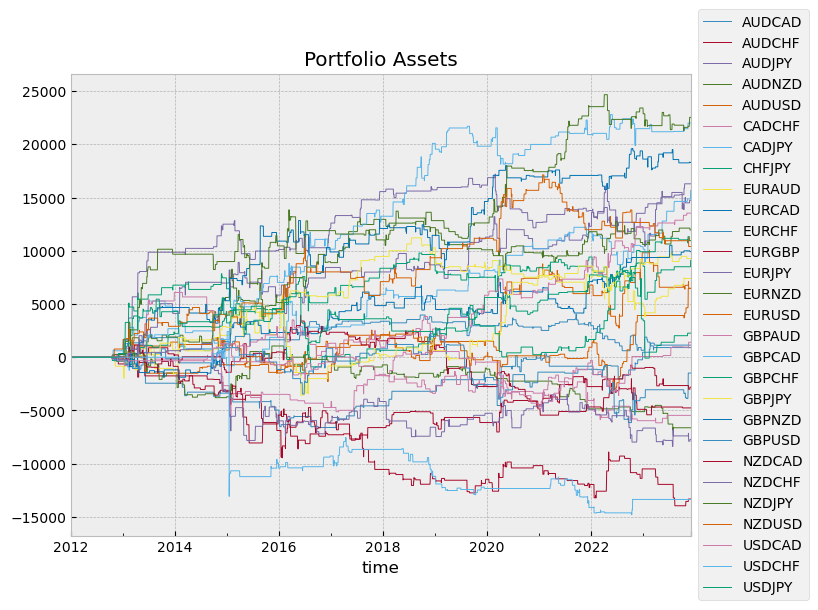

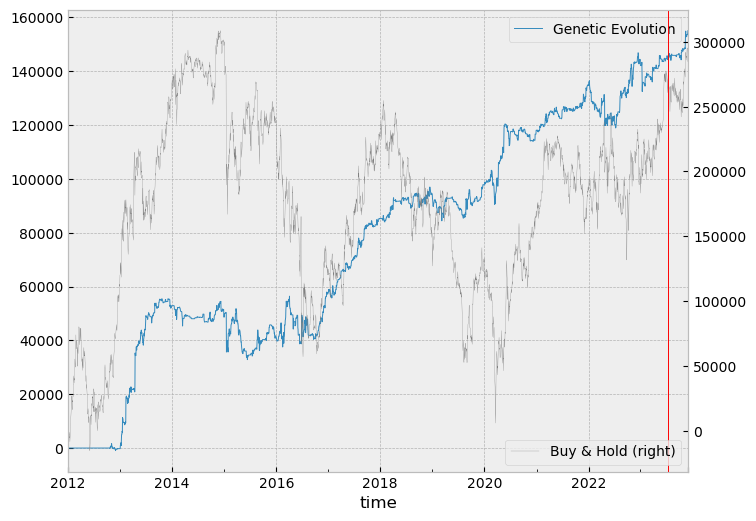

In [10]:
tradelist = backtest(best_solution)

                           Strategy
-------------------------  ----------
Start Period               2012-05-25
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          219.39%
CAGR﹪                     7.21%

Sharpe                     1.3
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.25
Sortino                    2.26
Smart Sortino              2.17
Sortino/√2                 1.59
Smart Sortino/√2           1.54
Omega                      1.39

Max Drawdown               -12.26%
Longest DD Days            482
Volatility (ann.)          11.9%
Calmar                     0.59
Skew                       3.01
Kurtosis                   55.36

Expected Daily %           0.06%
Expected Monthly %         0.84%
Expected Yearly %          10.16%
Kelly Criterion            14.83%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.17%
Expected Shortfall (cVaR)  -1.17%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-01-03,2014-10-06,2014-11-21,323,-12.261349,-11.857272
2,2015-01-16,2015-01-16,2015-03-20,64,-8.423244,-8.355329
3,2015-12-16,2016-02-23,2016-03-25,101,-8.026421,-7.986777
4,2012-06-28,2012-07-24,2012-09-13,78,-6.854850,-5.987204
5,2020-02-06,2020-03-13,2020-04-08,63,-6.655606,-6.322579


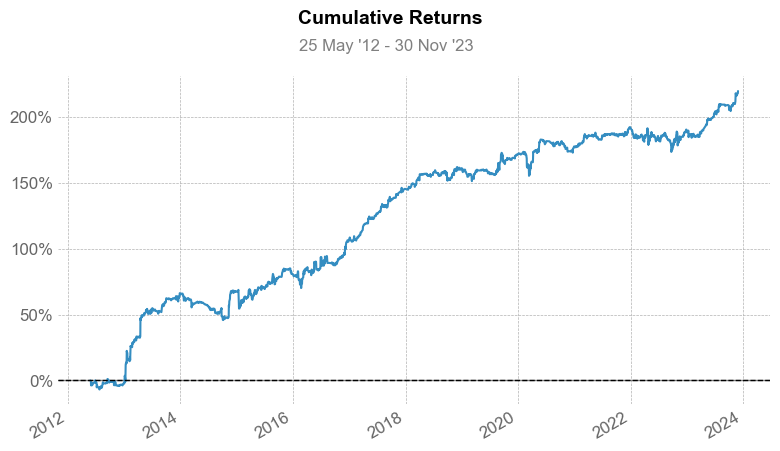

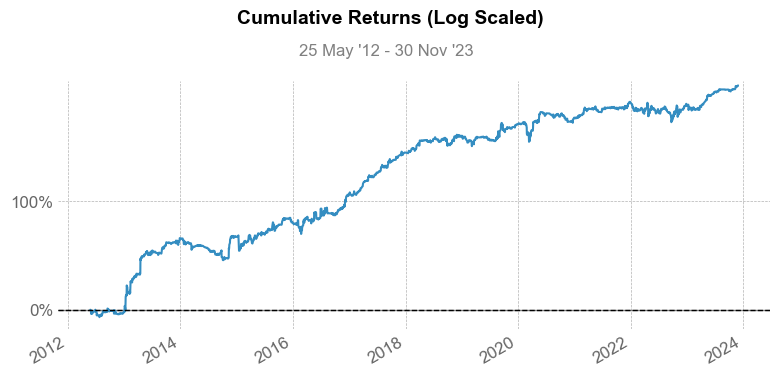

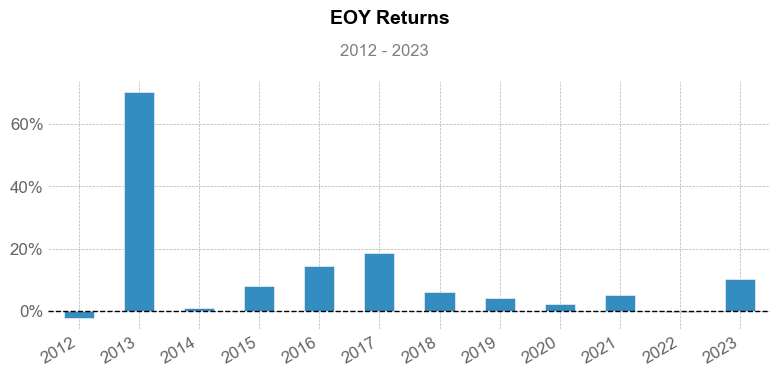

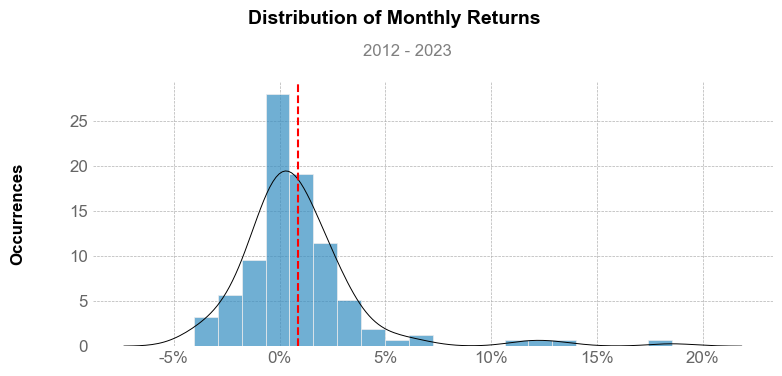

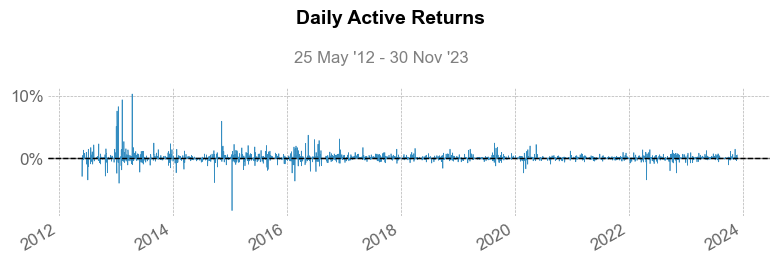

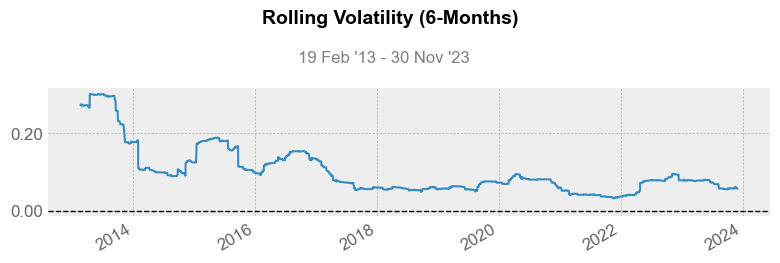

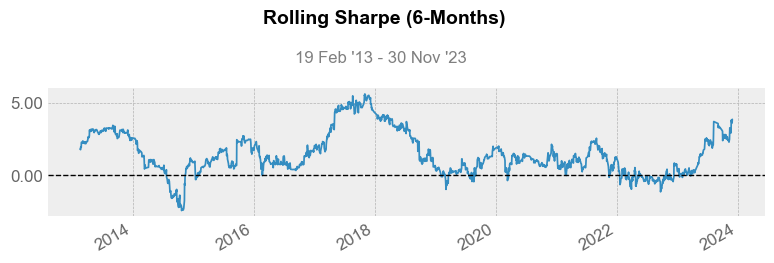

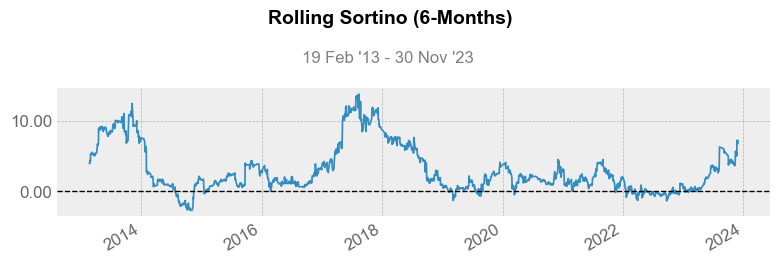

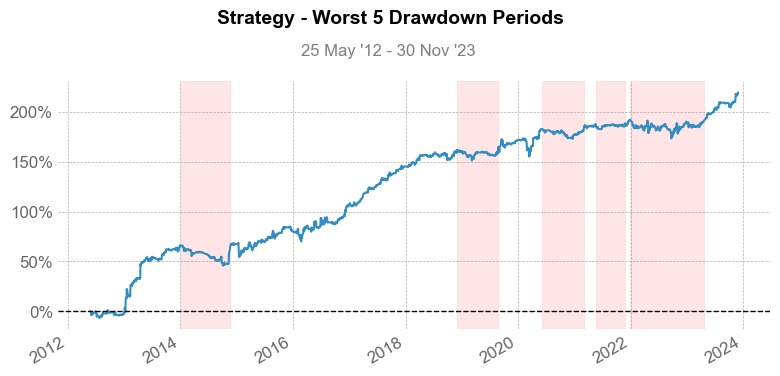

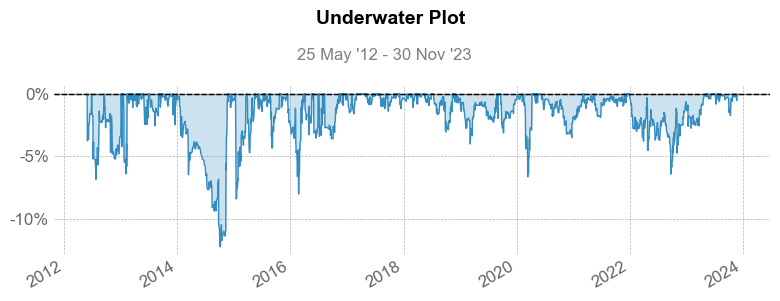

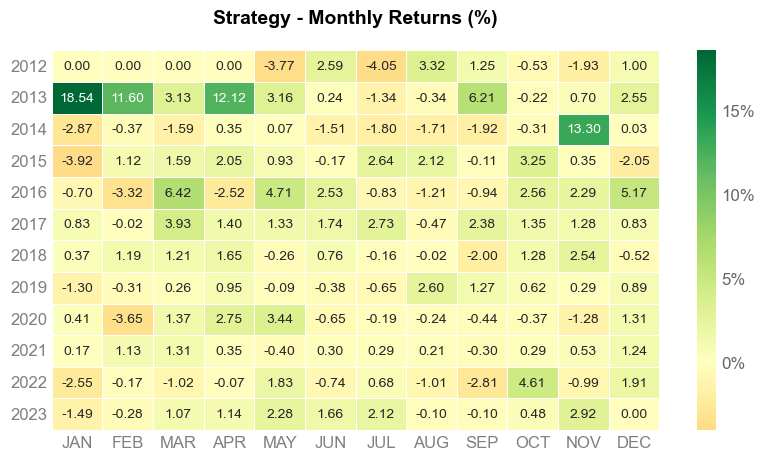

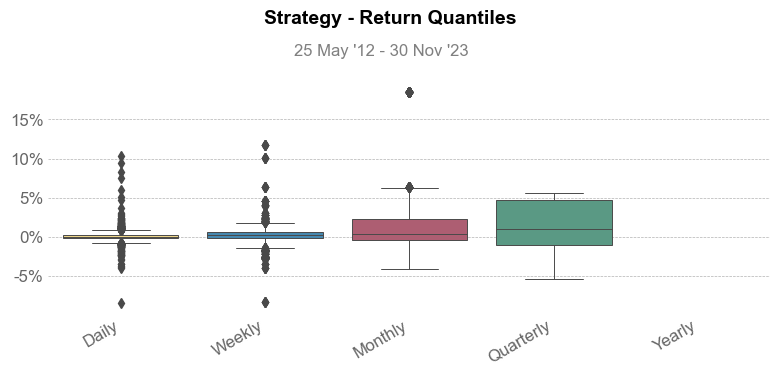

In [104]:
report(tradelist.sum(axis=1) ,100000 ,2,"")

In [11]:
eval("(sharpe_ratio(5).shift(3)>sharpe_ratio(100).shift(2)) & (avg_close(100).shift(2)>avg_close(5).shift(1)) & (std_close(5).shift(5)>std_close(200).shift(4))")

NameError: name 'dataset_perc' is not defined